In [ ]:
#default_exp data.augment

# Data augmentation

> Transforms that have different behavior for different parts of their input

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

In [ ]:
Mask = partial(Imagify(cmap='tab20', alpha=0.5, vmin=1, vmax=30))

## Transforms

### General arch

In [ ]:
class DataAugTransform(Transform):
    is_tuple=True
    "A transform that randomize its state at each `__call__`"
    def __init__(self, types=None): self.types=types
    def randomize(self, b): pass
    def _masked(self,b):
        #Change default mask to be applied on all coords since there is going to be dispatch that defaults to noop
        mask = [True for i in range_of(b)] if self.mask is None and self.is_tuple else self.mask
        #Add types to pass them to encodes
        types = [Item for i in range_of(b)] if self.types is None else self.types
        return zip(b,types,mask)

    def _apply(self, f, b, filt, **kwargs):
        if not self._filt_match(filt): return b
        if not self.is_tuple: return f(b, **kwargs)
        return tuple(f(o, t, **kwargs) if p else o for o,t,p in self._masked(b))
    
    def __call__(self, b, filt=None, **kwargs): 
        self.randomize(b) #Randomize before calling
        return super().__call__(b, filt=filt, **kwargs)

### PIL transforms

In [ ]:
class PILFlipImage(DataAugTransform):
    "Randomly flip an image with PIL"
    order = 10
    def __init__(self, assoc=None,p=0.5,types=None): self.p,self.assoc,self.types = p,assoc,types
    def randomize(self, b): self.do = random.random() < self.p
        
    def encodes(self, x, t):
        if not self.do: return x
        #Pretend dispatch
        if t == Image: return x.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        if t == Mask:  return x.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        return x

In [ ]:
class PILDihedral(DataAugTransform):
    "Apply random dihedral transform"
    order = 10
    def __init__(self, p=0.5,types=None): self.p,self.types = p,types
    def randomize(self, b): 
        self.idx = random.randint(0,7) if random.random() < self.p else 0
    
    def encodes(self, x, t):
        if not self.idx==0: return x
        #Pretend dispatch
        if t == Image: return x.transpose(self.idx-1)
        if t == Mask:  return x.transpose(self.idx-1)
        return x

### Affine tfm on the GPU

In [ ]:
class AffineTfm(DataAugTransform):
    "Combine and apply random affine transforms"
    order = 30
    def __init__(self, aff_tfms, size=None, mode='bilinear', padding_mode='reflection', types=None):
        self.aff_tfms,self.mode,self.padding_mode,self.types = aff_tfms,mode,padding_mode,types
        self.size = None if size is None else (size,size) if isinstance(size, int) else tuple(size)
    
    def randomize(self, b): [t.randomize(b[0]) for t in self.aff_tfms]
    
    def _get_affine_mat(self, x):
        aff_m = torch.eye(3, dtype=x.dtype, device=x.device)
        aff_m = aff_m.unsqueeze(0).expand(x.size(0), 3, 3)
        ms = [tfm() for tfm in self.aff_tfms]
        ms = [m for m in ms if m is not None]
        for m in ms: aff_m = aff_m @ m
        return aff_m
    
    def apply_img(self, x):
        "Apply function for an image"
        bs = x.size(0)
        size = tuple(x.shape[-2:]) if self.size is None else self.size
        size = (bs,x.size(1)) + size
        coords = F.affine_grid(self._get_affine_mat(x)[:,:2], size)
        return F.grid_sample(x, coords, mode=self.mode, padding_mode=self.padding_mode)
    
    def apply_mask(self, y):
        "Apply function for an segmentation mask"
        self.old_mode,self.mode = self.mode,'nearest'
        res = self.apply_img(y.float())
        self.mode = self.old_mode
        return res.long()
    
    def encodes(self, x, t):
        #Pretend dispatch
        if t == Image: return self.apply_img(x)
        if t == Mask:  return self.apply_mask(x)
        return x

In [ ]:
# export
import math
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

class FlipAffine():
    "Flip as an affine transform"
    def __init__(self, p=0.5): self.p=p
    
    def randomize(self, x):
        mask = -2*x.new_empty(x.size(0)).bernoulli_(self.p)+1
        self.mat = stack([stack([mask,     t0(mask), t0(mask)], dim=1),
                          stack([t0(mask), t1(mask), t0(mask)], dim=1),
                          stack([t0(mask), t0(mask), t1(mask)], dim=1)], dim=1)
    
    def __call__(self): return self.mat

In [ ]:
# export
def mask_tensor(x, p=0.5, neutral=0.):
    "Mask elements of `x` with probability `p` by replacing them with `neutral`"
    if p==1.: return x
    if neutral != 0: x.add_(-neutral)
    mask = x.new_empty(*x.size()).bernoulli_(p)
    x.mul_(mask)
    return x.add_(neutral) if neutral != 0 else x

In [ ]:
# export
class DihedralAffine():
    "Dihedral as an affine transform"
    def __init__(self, p=0.5): self.p=p
    
    def randomize(self, x):
        idx = mask_tensor(torch.randint(0, 8, (x.size(0),), device=x.device), p=self.p)
        xs = 1 - 2*(idx & 1)
        ys = 1 - (idx & 2)
        m0,m1 = (idx<4).long(),(idx>3).long()
        self.mat = stack([stack([xs*m0,  xs*m1,  t0(xs)], dim=1),
                          stack([ys*m1,  ys*m0,  t0(xs)], dim=1),
                          stack([t0(xs), t0(xs), t1(xs)], dim=1)], dim=1).float()
    
    def __call__(self): return self.mat

## Integration test

### Pets

In [ ]:
source = untar_data(URLs.PETS)/"images"
items = [get_image_files(source)[0]]*100
split_idx = L(range(80)), L(range(80,100))
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')

In [ ]:
tfms = [Imagify(), [labeller, Categorize()]]
ds_img_tfms = [ImageResizer(128), ImageToByteTensor(), PILFlipImage(types=(Image, Categorize))]
dl_tfms = [Cuda(), ByteToFloatTensor()]

In [ ]:
pets = DataSource.build(items, tfms, split_idx, ds_img_tfms)
trn_dl = TfmdDL(pets.train, dl_tfms, 4)

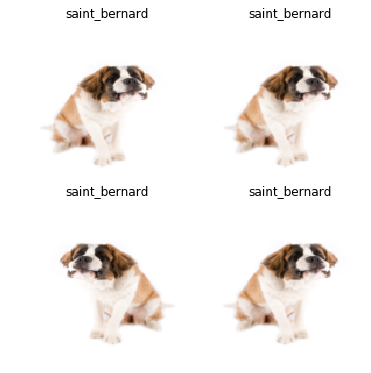

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

In [ ]:
tfms = [Imagify(), [labeller, Categorize()]]
ds_img_tfms = [ImageResizer(128), ImageToByteTensor()] #PILFlipImage(types=(Image, Categorize))
dl_tfms = [Cuda(), ByteToFloatTensor(), AffineTfm(L(DihedralAffine()),types=(Image,Categorize))]

In [ ]:
pets = DataSource.build(items, tfms, split_idx, ds_img_tfms)
trn_dl = TfmdDL(pets.train, dl_tfms, 4)

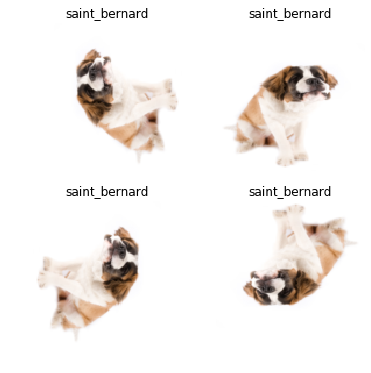

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

### Segmentation

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
ds_img_tfms = [ImageResizer(128), ImageToByteTensor(), PILFlipImage(types=(Image,Mask))]
dl_tfms = [Cuda(), ByteToFloatTensor()]
for t in ds_img_tfms: t.mask = (True,True)
tfms = [[Imagify()],
        [cv_label, Imagify(cmap='tab20', alpha=0.5, vmin=1, vmax=30)]]
camvid = DataSource.build(cv_items, tfms, cv_split, ds_img_tfms)
trn_dl = TfmdDL(camvid.train, dl_tfms, 4)

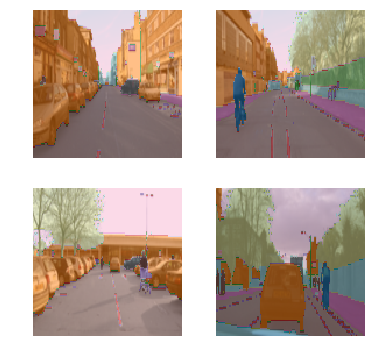

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

In [ ]:
ds_img_tfms = [ImageResizer(128), ImageToByteTensor()]
dl_tfms = [Cuda(), ByteToFloatTensor(), AffineTfm(L(DihedralAffine()),types=(Image,Mask))]
for t in ds_img_tfms: t.mask = (True,True)
tfms = [[Imagify()],
        [cv_label, Imagify(cmap='tab20', alpha=0.5, vmin=1, vmax=30)]]
camvid = DataSource.build(cv_items, tfms, cv_split, ds_img_tfms)
trn_dl = TfmdDL(camvid.train, dl_tfms, 4)

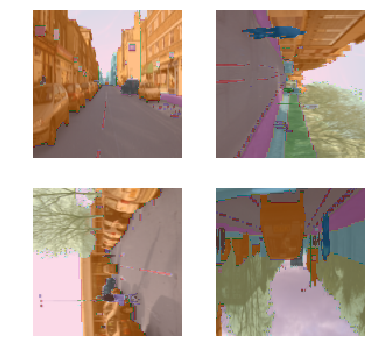

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

In [ ]:
# Also adds `p` param (defaults to 1)
AugRotate = make_augment(rotate, degrees=RandFloat(0,90))

In [ ]:
# Creates Image.rotate
@patch
def rotate(x:Image, degrees):
    return ...